In [2]:
# 必要なパッケージをインポートする
import keras
import cv2
import numpy as np
from glob import glob

# 画像を表示するためにmatplotlibをインポートする
import matplotlib.pyplot as plt
%matplotlib inline

# 相対パスを書くために、現在のディレクトリの位置を書き出す
import os
os.getcwd()


Using TensorFlow backend.


'd:\\My_programing\\python\\AI\\Training\\LeNet'

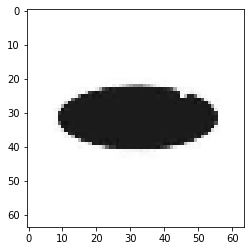

In [3]:
path = 'D:/My_programing/python/AI/DataSet/AngleDetection/training/0/chipping/299x299_image1.jpg'
                
x = cv2.imread(path)
x = cv2.resize(x, (64, 64)).astype(np.float32)
x /= 255.

#plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.imshow(x)
#print(x)

In [4]:
def data_load(path, img_width, img_height, CLS, Framework='Tensorflow'):
    """ファイルパスからデータセットをロードするための関数"""
    xs = [] # 訓練データ用の空リスト
    ts = [] # データラベル用の空リスト
    paths = [] # ロードしたファイルパス用の空リスト
    img_read_err = [] # ロードできなかったファイルパス用の空リスト
    lbl_err_path = [] # 正解ラベル作成時にエラーとなった画像のパスを保存するリスト
    err_cnt = 0
    num_classes = len(CLS)+1

    # データをロードするためにディレクトリを下りていく
    for dir_path_1 in glob(DirPath):
        for dir_path_2 in glob(dir_path_1 + '/*'):
            for path in glob(dir_path_2 + '/*'):
                #print(path, 'を読み込みました。')

                # 訓練用画像を読み込む
                x = cv2.imread(path)
                if x is None: # もし，画像がロードできなかった場合
                    print(path, 'を読み込めませんでした．')
                    img_read_err.append(path)
                    continue
                else: # 画像がロードできた場合
                    x = cv2.resize(x, (img_width, img_height)).astype(np.float32)
                    x /= 255.
                    xs.append(x)
                
                # 正解ラベルを作成する
                lbl = dir_path_1[dir_path_1.find('\\'):].strip('\\')
                # 使用するフレームワークによって，正解ラベルの作成方法が異なる
                if (Framework is 'PyTorch'):
                    t = float(lbl)
                elif (Framework is 'Tensorflow') or (Framework is 'Keras'):
                    # one-hot-labelを作成する
                    t = np.zeros(num_classes)
                    for i, cls in enumerate(CLS):
                        if cls == lbl:
                            t[i] = 1
                    if np.sum(t) != 1:
                        lbl_err_path.append(path)
                        err_cnt +=1

                #print(t)
                ts.append(t)
                paths.append(path)

    xs = np.array(xs, dtype=np.float32)
    ts = np.array(ts, dtype=np.int)

    return xs, ts, paths, img_read_err, lbl_err_path

In [5]:
# LeNetを作成する
## Network
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization

def LeNet(img_width, img_height, num_classes):
    inputs = Input((img_height, img_width, 3))
    x = Conv2D(6, (5, 5), padding='valid', activation=None, name='conv1')(inputs)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = Activation('sigmoid')(x)
    x = Conv2D(16, (5, 5), padding='valid', activation=None, name='conv2')(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(120, name='dense1', activation=None)(x)
    x = Dense(64, name='dense2', activation=None)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x, name='model')
    return model

In [6]:
# training
def train(DirPath, img_size, cls_label):
    model = LeNet(img_size[0], img_size[1], len(cls_label)+1)

    for layer in model.layers:
        layer.trainable = True

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
        metrics=['accuracy'])
    
    xs, ts, paths, img_read_err, err_path = data_load(DirPath, img_size[0], img_size[1], cls_label)
    if img_read_err:
        print('画像の読み込みでエラーが発生しました．')
        print(img_read_err)
        pass
    elif err_path:
        print('one_hot_lbl作成時にエラーが発生しました．')
        print(err_path)
        pass

    # training
    mb = 100
    mbi = 0
    count = 1
    loss_ls = []

    loss_ave = 0
    loss_AveMin = 1
    loss_AveCnt = 0
    #loss_AveLs = []

    train_ind = np.arange(len(xs))
    np.random.seed(0)
    np.random.shuffle(train_ind)

    #for i in range(500):
    while True:
        if mbi + mb > len(xs):
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[:(mb-(len(xs)-mbi))]))
            mbi = mb - (len(xs) - mbi)
            
            loss_ave = np.average(loss_ls)
            if loss_AveMin > loss_ave:
                loss_AveMin = loss_ave
                loss_AveCnt = 0
            else: loss_AveCnt += 1
            loss_ls = []
            print('iter >>', count, ',loss_ave >>', loss_ave, 'accuracy >>', acc)
        else:
            mb_ind = train_ind[mbi: mbi+mb]
            mbi += mb

        x = xs[mb_ind]
        t = ts[mb_ind]

        loss, acc = model.train_on_batch(x=x, y=t)
        #print('iter >>', count, ',loss >>', loss, 'accuracy >>', acc)
        
        loss_ls.append(loss)
        count += 1

        if loss_AveCnt == 50: break

    model.save('LeNet.h5')
    return 0

In [8]:
# データを読み込むフォルダを指定する
DirPath = '../../../DataSet/AngleDetection/training/*'
#print(DirPath)

num_classes = 36
img_width, img_height = 64, 64
CLS = np.arange(0, 180, 5).astype('str')

#train(DirPath, img_size=(64, 64), cls_label=CLS)
train(DirPath, img_size=(img_width, img_height), cls_label=CLS)

UnboundLocalError: local variable 'acc' referenced before assignment